# Now creating a new script for first computing density from the dataset, then creating a grid with the same x-distance, then computing windstress and aligning with the ferrybox data by interpolating windstress data to the ferrybox.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
from pathlib import Path
import cmocean as cmo
import numpy as np
import gsw
from pathlib import Path

In [ ]:
# Function to load ONE file
def load_files(filepath: str | Path) -> pd.DataFrame:
    """
    Read an SBE text export that has metadata lines before the real header.
    Returns a tidy DataFrame with an extra 'datetime' column.
    """
    filepath = Path(filepath)

    # detect how many metadata lines to skip ------------------
    with filepath.open('r', encoding='latin1') as f:
        for i, line in enumerate(f):
            if line.strip().startswith("Date") and "Time" in line:
                skiprows = i
                break

    # read the rest ------------------------------------------
    df = pd.read_csv(
        filepath,
        sep=r'\s+',                 # whitespace delimiter
        skiprows=skiprows,          # jump over metadata
        encoding='latin1'
    )

    # combine date/time to real datetime ----------------------
    df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
    df['source']   = filepath.stem   # keep the filename → handy for legends
    df = df.iloc[1:]                # drop the first data row
    return df


# 2.  Load desired files

files = [
    #r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\224_2025-05-06_07.35.09__to_Skagen_741601.txt", #Dag 1 
    #r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\2025-05-07_07.11.44_Skagen_to__741601.txt", # Halva dag 2
    r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\225_2025-05-07_07.11.44_Skagen_to_Skagen_741601.txt", # Hela dag 2
    #r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\2025-05-08_07.24.29_Skagen_to__741601.txt" #Dag 3
]
dfs = [load_files(f) for f in files]

# Concatenate if you just want one big table:
df_all = pd.concat(dfs, ignore_index=True)

Remove/Interpolate the outlier in the transect from skagen to gbg, last day

In [ ]:
# New way thats working
# There is one outlier in the temp data, I will flag it and then interpolate inbetween

# # flag outliers
# bad = df_all['Temp_in_SBE38'] > 100            # any value > 100 °C is impossible  
# df_all.loc[bad, 'Temp_in_SBE38'] = np.nan      # set those outliers to NaN

df_all['Temp_in_SBE38'] = df_all['Temp_in_SBE38'].mask(df_all['Temp_in_SBE38'] > 100)

# # interpolate the gaps
# df_all = df_all.set_index('datetime')              # make time the index  
# df_all['Temp_in_SBE38'] = df_all['Temp_in_SBE38'].interpolate('time')  # linear fill in time  
# df_all = df_all.reset_index()                      # restore datetime as a column

Get the sigma density and Cons. temp and abs. sal

In [ ]:
# Convert everything to TEOS-10
SP  = df_all['Salinity_SBE45'].to_numpy()   # practical salinity is what we have in the dataset, will convert to Absolute sal
T   = df_all['Temp_in_SBE38'].to_numpy()    # in-situ temp (°C, ITS-90), will convert to Conservative T
p   = df_all['pressure'].to_numpy() / 100.0    # mbar → dbar  (1 dbar = 100 mbar)
lon = df_all['Longitude'].to_numpy()
lat = df_all['Latitude'].to_numpy()

SA = gsw.SA_from_SP(SP, p, lon, lat)    # absolute salinity
CT = gsw.CT_from_t(SA, T, p)            # conservative temp

# Store everything in the the dataset
df_all['SA'] = SA
df_all['CT'] = CT
df_all['sigma0'] = gsw.sigma0(SA, CT)       # potential density anomaly σθ

Open the weather data to compute the Ekman bouyancy flux

In [ ]:
df_wind = pd.read_csv(r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\sk_weather.csv")
df_pos = pd.read_csv(r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\sk_position.csv")

In [ ]:
df_wind['ts'] = pd.to_datetime(df_wind['ts']).dt.round('1s')
df_pos['ts'] = pd.to_datetime(df_pos['ts']).dt.round('1s')

df = pd.merge(df_pos, df_wind, on='ts', how='inner')

In [ ]:
df

,Time,Latitude,Longitude,gndspeed,gndcourse,gps_quality,nbused,hdop,airtemp,humidity,airpressure,windspeed,winddir,datetime
0,2025-05-06 07:00:00,57.686355,11.893357,0.0,329.60,5,9,1.3,8.8,42,1014.2,3.4,12,2025-05-06 07:00:00
1,2025-05-06 07:01:00,57.686355,11.893356,0.0,96.92,5,9,1.3,8.8,42,1014.2,3.3,13,2025-05-06 07:01:00
2,2025-05-06 07:02:00,57.686355,11.893358,0.0,156.77,5,9,1.3,8.8,43,1014.3,3.1,332,2025-05-06 07:02:00
3,2025-05-06 07:03:00,57.686355,11.893356,0.0,95.12,5,9,1.3,8.8,42,1014.2,2.5,7,2025-05-06 07:03:00
4,2025-05-06 07:04:00,57.686363,11.893342,0.0,247.44,5,9,1.3,8.9,42,1014.2,3.8,356,2025-05-06 07:04:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3253,2025-05-08 13:13:00,57.642033,11.665780,7.2,65.03,5,8,1.1,11.0,59,1018.7,3.6,275,2025-05-08 13:13:00
3254,2025-05-08 13:14:00,57.642999,11.669698,9.5,66.01,5,8,1.1,11.1,60,1018.6,0.5,170,2025-05-08 13:14:00
3255,2025-05-08 13:15:00,57.644032,11.674796,11.1,71.54,5,8,1.1,11.1,57,1018.5,0.8,297,2025-05-08 13:15:00
3256,2025-05-08 13:16:00,57.644881,11.680356,11.2,74.19,5,9,1.1,11.0,56,1018.5,1.7,281,2025-05-08 13:16:00


In [ ]:
df = df.rename(columns={'ts': 'Time'})
df = df.rename(columns={'longitude': 'Longitude'})
df = df.rename(columns={'latitude': 'Latitude'})

In [ ]:
df_all['datetime'] = pd.to_datetime(df_all['Date'].astype(str) + ' ' + df_all['Time'].astype(str))
df['datetime'] = pd.to_datetime(df['Time'])

df_all = df_all.sort_values('datetime')
df = df.sort_values('datetime')


In [ ]:
from scipy.spatial import cKDTree
import numpy as np

# Create arrays of coordinates: (Latitude, Longitude) → convert to radians for distance
wind_coords = np.radians(df[['Latitude', 'Longitude']].to_numpy())
ferry_coords = np.radians(df_all[['Latitude', 'Longitude']].to_numpy())

# Build tree from wind positions
tree = cKDTree(wind_coords)

# Query nearest neighbor in wind data for each ferrybox point
dist_rad, idx = tree.query(ferry_coords, k=1)

# Convert radians to meters (~Earth radius)
earth_radius = 6371000  # meters
dist_m = dist_rad * earth_radius


In [ ]:
# Create a new merged DataFrame
df_all_spatial = df_all.copy()

# Add columns from nearest wind row to each ferrybox row
nearest_wind = df.iloc[idx].reset_index(drop=True)
nearest_wind = nearest_wind.add_suffix('_wind')

df_all_spatial = pd.concat([df_all_spatial.reset_index(drop=True), nearest_wind], axis=1)
df_all_spatial['gps_spatial_offset_m'] = dist_m


In [ ]:
# Ensure both columns are datetime
df_all_spatial['datetime'] = pd.to_datetime(df_all_spatial['datetime'])
df_all_spatial['Time_wind'] = pd.to_datetime(df_all_spatial['Time_wind'])

# Time difference in seconds
df_all_spatial['time_offset_s'] = (df_all_spatial['Time_wind'] - df_all_spatial['datetime']).dt.total_seconds()


In [ ]:
df_filtered = df_all_spatial[np.abs(df_all_spatial['time_offset_s']) < 300].copy() # .copy ensures it's a true independent DataFrame
print(df_filtered.shape)
print(df_filtered['gps_spatial_offset_m'].describe())


(293, 43)
count    293.000000
mean      87.735575
std       81.396908
min        1.697317
25%        9.781362
50%       78.174067
75%      156.786779
max      301.933950
Name: gps_spatial_offset_m, dtype: float64


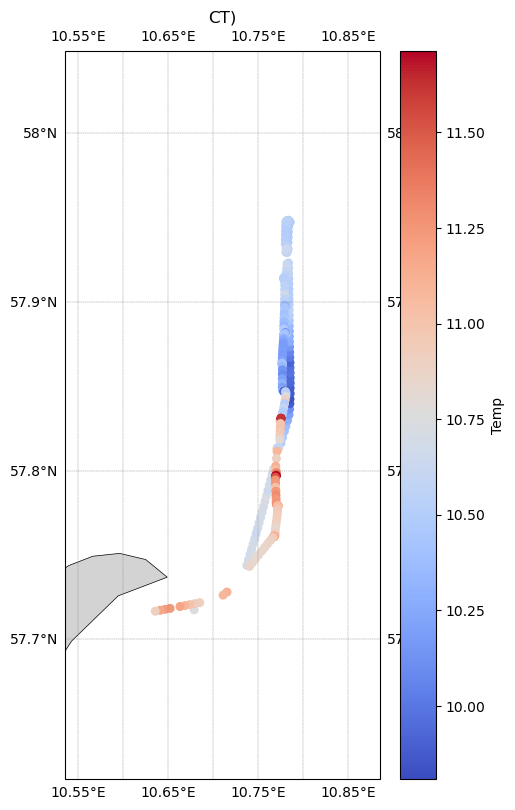

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Mercator())

# Define extent with buffer
lat_min, lat_max = df_filtered['Latitude'].min(), df_filtered['Latitude'].max()
lon_min, lon_max = df_filtered['Longitude'].min(), df_filtered['Longitude'].max()
extent = [lon_min - 0.1, lon_max + 0.1, lat_min - 0.1, lat_max + 0.1]

ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', linestyle='--')

# Scatter plot of Q_EBF
sc = ax.scatter(df_filtered['Longitude'], df_filtered['Latitude'],
                c=df_filtered['CT'], cmap='coolwarm', s=30,
                transform=ccrs.PlateCarree())

# Colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Temp')

ax.set_title('CT    ')
plt.tight_layout()
plt.show()


Compute windstress

In [ ]:
# Get windstress

# ── 2.  vectorised air-density ρ_a(T, p, RH) ───────────────────────────
T   = df_filtered['airtemp_wind'].to_numpy(float)         # °C
P   = df_filtered['airpressure_wind'].to_numpy(float) * 100    # hPa → Pa
RH  = df_filtered['humidity_wind'].to_numpy(float) / 100     # %

Rd, Rv = 287.05, 461.5
es = 611.2 * np.exp((17.67 * T) / (T + 243.5))   # Pa (sat. vapour press.)
e  = RH * es                                     # Pa (actual vapour press.)
rho_air = (P - e) / (Rd * (T + 273.15)) + e / (Rv * (T + 273.15))

# ── 3.  wind-vector components (u, v) from speed + “from” direction ────
U     = df_filtered['windspeed_wind'].to_numpy(float)          # m s⁻¹
theta = np.deg2rad(df_filtered['winddir_wind'].to_numpy(float))

u = -U * np.sin(theta)      # eastward (+ = toward east)
v = -U * np.cos(theta)      # northward (+ = toward north)

# ── 4.  constant drag coefficient & wind-stress components ─────────────
Cd   = 1.5e-3                                    # dimensionless
tau  = rho_air * Cd * U**2                       # magnitude  (N m⁻²)
tau_x = rho_air * Cd * U * u                     # eastward stress
tau_y = rho_air * Cd * U * v                     # northward stress

# store in DataFrame
df_filtered['tau']   = tau
df_filtered['tau_x'] = tau_x
df_filtered['tau_y'] = tau_y

# ── 5.  quick sanity print ─────────────────────────────────────────────
print(df_filtered[['Time', 'Latitude', 'Longitude', 'tau', 'tau_x', 'tau_y']].head())

        Time   Latitude  Longitude       tau     tau_x     tau_y
10  07:24:00  57.717610  10.678879  0.114842 -0.064219 -0.095209
23  07:37:00  57.744031  10.737504  0.070327 -0.049728 -0.049728
24  07:38:00  57.747205  10.739215  0.065815 -0.051863 -0.040520
25  07:39:00  57.750384  10.740984  0.079882 -0.059364 -0.053451
26  07:40:00  57.753532  10.742713  0.070347 -0.054670 -0.044271


In [ ]:
print(df_filtered['tau'])

10     0.114842
23     0.070327
24     0.065815
25     0.079882
26     0.070347
         ...   
401    0.089738
403    0.092349
404    0.092323
405    0.070141
406    0.061235
Name: tau, Length: 293, dtype: float64


In [ ]:
print(df_filtered.columns)

Index(['Date', 'Time', 'Latitude', 'Longitude', 'Course', 'Speed',
       'Temp_SBE45', 'Cond_SBE45', 'Salinity_SBE45', 'SoundVel_SBE45',
       'Temp_in_SBE38', 'Oxygen', 'Saturation', 'Temperature_Optode', 'pH',
       'Chlorophyll', 'Turbidity', 'pressure', 'flow_main', 'flow_SBE45',
       'Phycocyanin', 'CDOM', 'datetime', 'source', 'SA', 'CT', 'sigma0',
       'Time_wind', 'Latitude_wind', 'Longitude_wind', 'gndspeed_wind',
       'gndcourse_wind', 'gps_quality_wind', 'nbused_wind', 'hdop_wind',
       'airtemp_wind', 'humidity_wind', 'airpressure_wind', 'windspeed_wind',
       'winddir_wind', 'datetime_wind', 'gps_spatial_offset_m',
       'time_offset_s', 'tau', 'tau_x', 'tau_y'],
      dtype='object')


Now I want to compute the Bouyancy gradient

In [ ]:
# Method 2

import numpy as np
from pyproj import Geod
from scipy.interpolate import interp1d

# Constants
g = 9.81                 # gravity (m/s^2)
target_depth = 2.0       # target depth (meters)
depth_window = 0.5       # allowable depth variation (± meters)

# Step 1: Filter to measurements near the target depth
df_filtered['Depth'] = -gsw.z_from_p(df_filtered['pressure'] / 100, df_filtered['Latitude'])

depth = df_filtered["Depth"].to_numpy()
mask = np.abs(depth - target_depth) <= depth_window

# Only continue if we have enough points
if np.sum(mask) < 10:
    raise ValueError("Not enough points near the target depth for reliable gradient computation.")

# Subset data near the target depth
df_near_depth = df_filtered[mask].copy()
lon = df_near_depth["Longitude"].to_numpy()
lat = df_near_depth["Latitude"].to_numpy()
sigma0 = df_near_depth["sigma0"].to_numpy()

# Step 2: Compute rho0 as mean density of filtered data
rho = sigma0 + 1000.0
rho0 = np.nanmean(rho)

# Step 3: Compute buoyancy
b = g * (1 - rho / rho0)

# Step 4: Compute cumulative distance along track
geod = Geod(ellps="WGS84")
_, _, step = geod.inv(lon[:-1], lat[:-1], lon[1:], lat[1:])
dist = np.concatenate(([0.0], np.cumsum(step)))  # distance in meters

# Step 5: Interpolate buoyancy to regular grid
dx = 500.0
d_reg = np.arange(0, dist[-1], dx)
b_reg = interp1d(dist, b, bounds_error=False, fill_value=np.nan)(d_reg)

# Step 6: Compute buoyancy gradient
dbdx_reg = np.gradient(b_reg, dx)  # units: 1/s²

# Step 7: Interpolate gradient back to original distances
buoy_grad = np.interp(dist, d_reg, dbdx_reg, left=np.nan, right=np.nan)

# Step 8: Store result
df_filtered["buoy_grad"] = buoy_grad


In [ ]:
import numpy as np
from pyproj import Geod
from scipy.interpolate import interp1d
import gsw

# Constants
g = 9.81                 # gravity (m/s^2)
target_depth = 2.0       # target depth (meters)
depth_window = 0.5       # allowable depth variation (± meters)
dx = 500.0              # horizontal resolution (meters)
geod = Geod(ellps="WGS84")

# Step 1: Convert pressure to depth (m)
df_filtered['Depth'] = -gsw.z_from_p(df_filtered['pressure'] / 100, df_filtered['Latitude'])
depth = df_filtered["Depth"].to_numpy()

print(f"\n--- DEPTH ---")
print(f"Min depth: {np.nanmin(depth):.3f} m, Max depth: {np.nanmax(depth):.3f} m")

# Step 2: Filter to ~2 m depth
mask = np.abs(depth - target_depth) <= depth_window
print(f"\n--- FILTER ---")
print(f"Points near {target_depth} m (±{depth_window} m): {np.sum(mask)} / {len(depth)}")

if np.sum(mask) < 10:
    raise ValueError("Not enough points near the target depth for reliable gradient computation.")

# Subset the filtered data
df_near_depth = df_filtered[mask].copy()
lon = df_near_depth["Longitude"].to_numpy()
lat = df_near_depth["Latitude"].to_numpy()
sigma0 = df_near_depth["sigma0"].to_numpy()

# Step 3: Compute density and buoyancy
rho = sigma0 + 1000.0
rho0 = np.nanmean(rho)
b = g * (1 - rho / rho0)

print(f"\n--- DENSITY ---")
print(f"rho0 (mean): {rho0:.3f} kg/m³")
print(f"rho range: {np.nanmin(rho):.3f} – {np.nanmax(rho):.3f} kg/m³")
print(f"buoyancy (b) range: {np.nanmin(b):.2e} – {np.nanmax(b):.2e} m/s²")

# Step 4: Compute cumulative distance along track

# Calculate distances
_, _, step = geod.inv(lon[:-1], lat[:-1], lon[1:], lat[1:])
dist = np.concatenate(([0.0], np.cumsum(step)))

# Filter out steps < threshold (e.g., 50 m)
valid = np.concatenate(([True], step > 50))
lon = lon[valid]
lat = lat[valid]
b = b[valid]
dist = np.concatenate(([0.0], np.cumsum(geod.inv(lon[:-1], lat[:-1], lon[1:], lat[1:])[2])))


# Recalculate step after filtering
_, _, step_filtered = geod.inv(lon[:-1], lat[:-1], lon[1:], lat[1:])
print(f"\n--- DISTANCE ---")
print(f"Step sizes (m): min {np.min(step_filtered):.1f}, max {np.max(step_filtered):.1f}")

print(f"Total distance: {dist[-1]:.1f} m")

# Step 5: Interpolate buoyancy onto regular grid
d_reg = np.arange(0, dist[-1], dx)
b_reg = interp1d(dist, b, bounds_error=False, fill_value=np.nan)(d_reg)

print(f"\n--- INTERPOLATED BUOYANCY ---")
print(f"b_reg range: {np.nanmin(b_reg):.2e} – {np.nanmax(b_reg):.2e} m/s²")
print(f"Interpolated points: {len(b_reg)}")

# Step 6: Compute buoyancy gradient
dbdx_reg = np.gradient(b_reg, dx)

print(f"\n--- BUOYANCY GRADIENT (∂b/∂x) ---")
print(f"Gradient range: {np.nanmin(dbdx_reg):.2e} – {np.nanmax(dbdx_reg):.2e} s⁻²")

# Step 7: Map gradient back to original points (irregular spacing)
buoy_grad = np.interp(dist, d_reg, dbdx_reg, left=np.nan, right=np.nan)
# Create a filtered dataframe that matches filtered lon/lat/b
df_clean = df_near_depth.iloc[valid].copy()
df_clean["buoy_grad"] = buoy_grad


print(f"\n--- FINAL buoy_grad on original points ---")
print(f"Range: {np.nanmin(buoy_grad):.2e} – {np.nanmax(buoy_grad):.2e} s⁻²")
print(f"Non-NaN values: {np.sum(~np.isnan(buoy_grad))} / {len(buoy_grad)}")



--- DEPTH ---
Min depth: 1.784 m, Max depth: 2.102 m

--- FILTER ---
Points near 2.0 m (±0.5 m): 293 / 293

--- DENSITY ---
rho0 (mean): 1022.846 kg/m³
rho range: 1022.032 – 1024.402 kg/m³
buoyancy (b) range: -1.49e-02 – 7.81e-03 m/s²

--- DISTANCE ---
Step sizes (m): min 52.0, max 4567.0
Total distance: 59748.2 m

--- INTERPOLATED BUOYANCY ---
b_reg range: -1.13e-02 – 7.67e-03 m/s²
Interpolated points: 120

--- BUOYANCY GRADIENT (∂b/∂x) ---
Gradient range: -6.27e-06 – 5.33e-06 s⁻²

--- FINAL buoy_grad on original points ---
Range: -6.07e-06 – 4.97e-06 s⁻²
Non-NaN values: 180 / 181


In [ ]:
# Recalculate step after filtering
_, _, step_filtered = geod.inv(lon[:-1], lat[:-1], lon[1:], lat[1:])

print("\nShortest steps with large buoyancy gradient:")
for i, step_val in enumerate(step_filtered):
    if step_val < 500:
        delta_b = b[i+1] - b[i]
        grad = delta_b / step_val
        print(f"Step {i}-{i+1}: {step_val:.1f} m, Δb = {delta_b:.2e}, ∂b/∂x = {grad:.2e} s⁻²")



Shortest steps with large buoyancy gradient:
Step 1-2: 367.9 m, Δb = -3.51e-05, ∂b/∂x = -9.53e-08 s⁻²
Step 2-3: 369.4 m, Δb = -1.35e-04, ∂b/∂x = -3.65e-07 s⁻²
Step 3-4: 365.4 m, Δb = -1.90e-04, ∂b/∂x = -5.19e-07 s⁻²
Step 4-5: 362.6 m, Δb = -2.20e-04, ∂b/∂x = -6.07e-07 s⁻²
Step 5-6: 362.9 m, Δb = -1.87e-04, ∂b/∂x = -5.15e-07 s⁻²
Step 6-7: 362.7 m, Δb = 1.34e-04, ∂b/∂x = 3.70e-07 s⁻²
Step 7-8: 367.8 m, Δb = -2.25e-04, ∂b/∂x = -6.10e-07 s⁻²
Step 8-9: 369.1 m, Δb = -1.10e-03, ∂b/∂x = -2.99e-06 s⁻²
Step 9-10: 370.4 m, Δb = -1.04e-03, ∂b/∂x = -2.81e-06 s⁻²
Step 10-11: 370.3 m, Δb = -2.81e-04, ∂b/∂x = -7.60e-07 s⁻²
Step 11-12: 371.0 m, Δb = -1.10e-03, ∂b/∂x = -2.96e-06 s⁻²
Step 12-13: 369.9 m, Δb = -3.88e-04, ∂b/∂x = -1.05e-06 s⁻²
Step 13-14: 369.8 m, Δb = -4.47e-04, ∂b/∂x = -1.21e-06 s⁻²
Step 14-15: 369.1 m, Δb = -1.01e-04, ∂b/∂x = -2.72e-07 s⁻²
Step 15-16: 367.2 m, Δb = 2.30e-03, ∂b/∂x = 6.26e-06 s⁻²
Step 16-17: 366.3 m, Δb = 4.68e-04, ∂b/∂x = 1.28e-06 s⁻²
Step 17-18: 366.3 m, Δb = 7.19e-0

In [ ]:
print(f"Step size range: {np.min(step_filtered):.1f} – {np.max(step_filtered):.1f} m")



Step size range: 52.0 – 4567.0 m


In [ ]:
from scipy.ndimage import uniform_filter1d
dbdx_reg_smooth = uniform_filter1d(dbdx_reg, size=3)


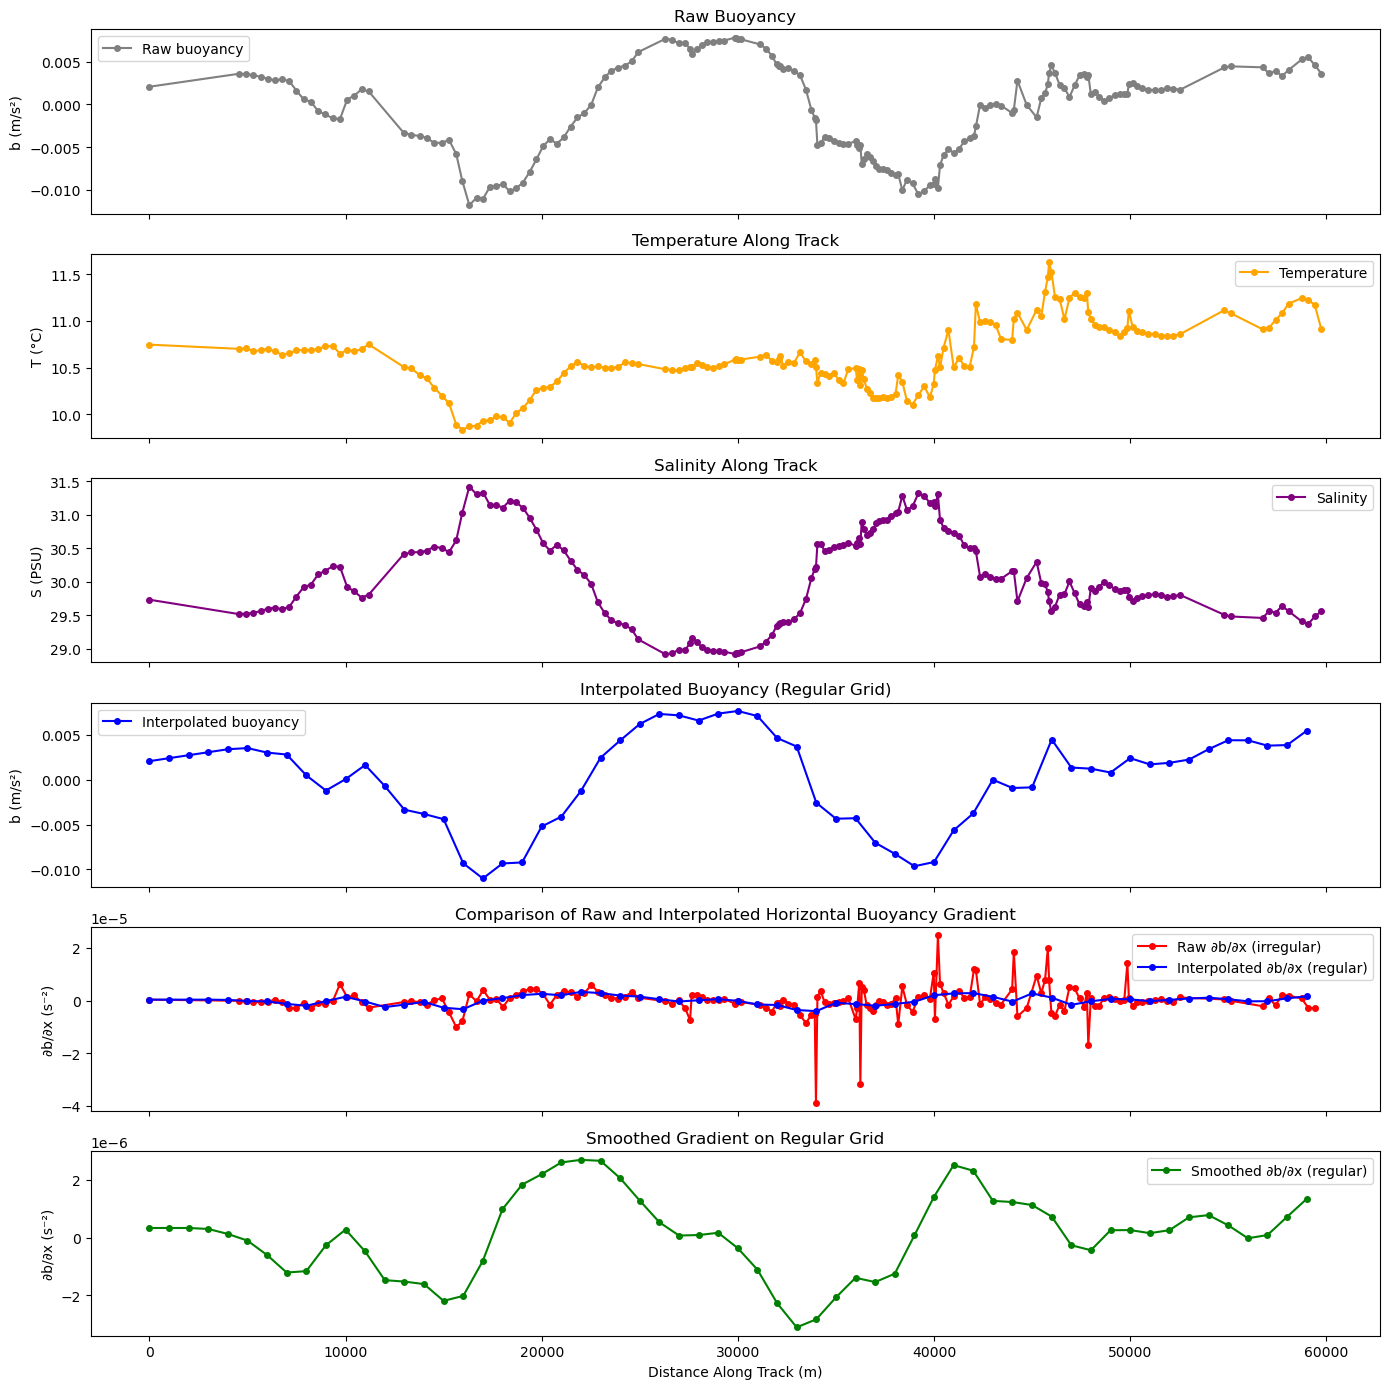

In [ ]:
fig, axs = plt.subplots(6, 1, figsize=(14, 14), sharex=True)

# 1. Raw buoyancy
axs[0].plot(dist, b, 'o-', color='gray', markersize=4, label='Raw buoyancy')
axs[0].set_ylabel("b (m/s²)")
axs[0].set_title("Raw Buoyancy")
axs[0].legend()

# 2. Temperature
axs[1].plot(dist, df_clean["CT"].to_numpy(), 'o-', color='orange', markersize=4, label='Temperature')
axs[1].set_ylabel("T (°C)")
axs[1].set_title("Temperature Along Track")
axs[1].legend()

# 3. Salinity
axs[2].plot(dist, df_clean["SA"].to_numpy(), 'o-', color='purple', markersize=4, label='Salinity')
axs[2].set_ylabel("S (PSU)")
axs[2].set_title("Salinity Along Track")
axs[2].legend()


# 4. Interpolated buoyancy
axs[3].plot(d_reg, b_reg, 'o-', color='blue', markersize=4, label='Interpolated buoyancy')
axs[3].set_ylabel("b (m/s²)")
axs[3].set_title("Interpolated Buoyancy (Regular Grid)")
axs[3].legend()

# 5. Raw vs Interpolated gradient
axs[4].plot(dist[:-1], np.diff(b) / step_filtered, 'o-', color='red', markersize=4, label='Raw ∂b/∂x (irregular)')
axs[4].plot(d_reg, dbdx_reg, 'o-', color='blue', markersize=4, label='Interpolated ∂b/∂x (regular)')
axs[4].set_ylabel("∂b/∂x (s⁻²)")
axs[4].set_title("Comparison of Raw and Interpolated Horizontal Buoyancy Gradient")
axs[4].legend()

# 6. Smoothed gradient
axs[5].plot(d_reg, dbdx_reg_smooth, 'o-', color='green', markersize=4, label='Smoothed ∂b/∂x (regular)')
axs[5].set_ylabel("∂b/∂x (s⁻²)")
axs[5].set_xlabel("Distance Along Track (m)")
axs[5].set_title("Smoothed Gradient on Regular Grid")
axs[5].legend()

plt.tight_layout()
plt.show()


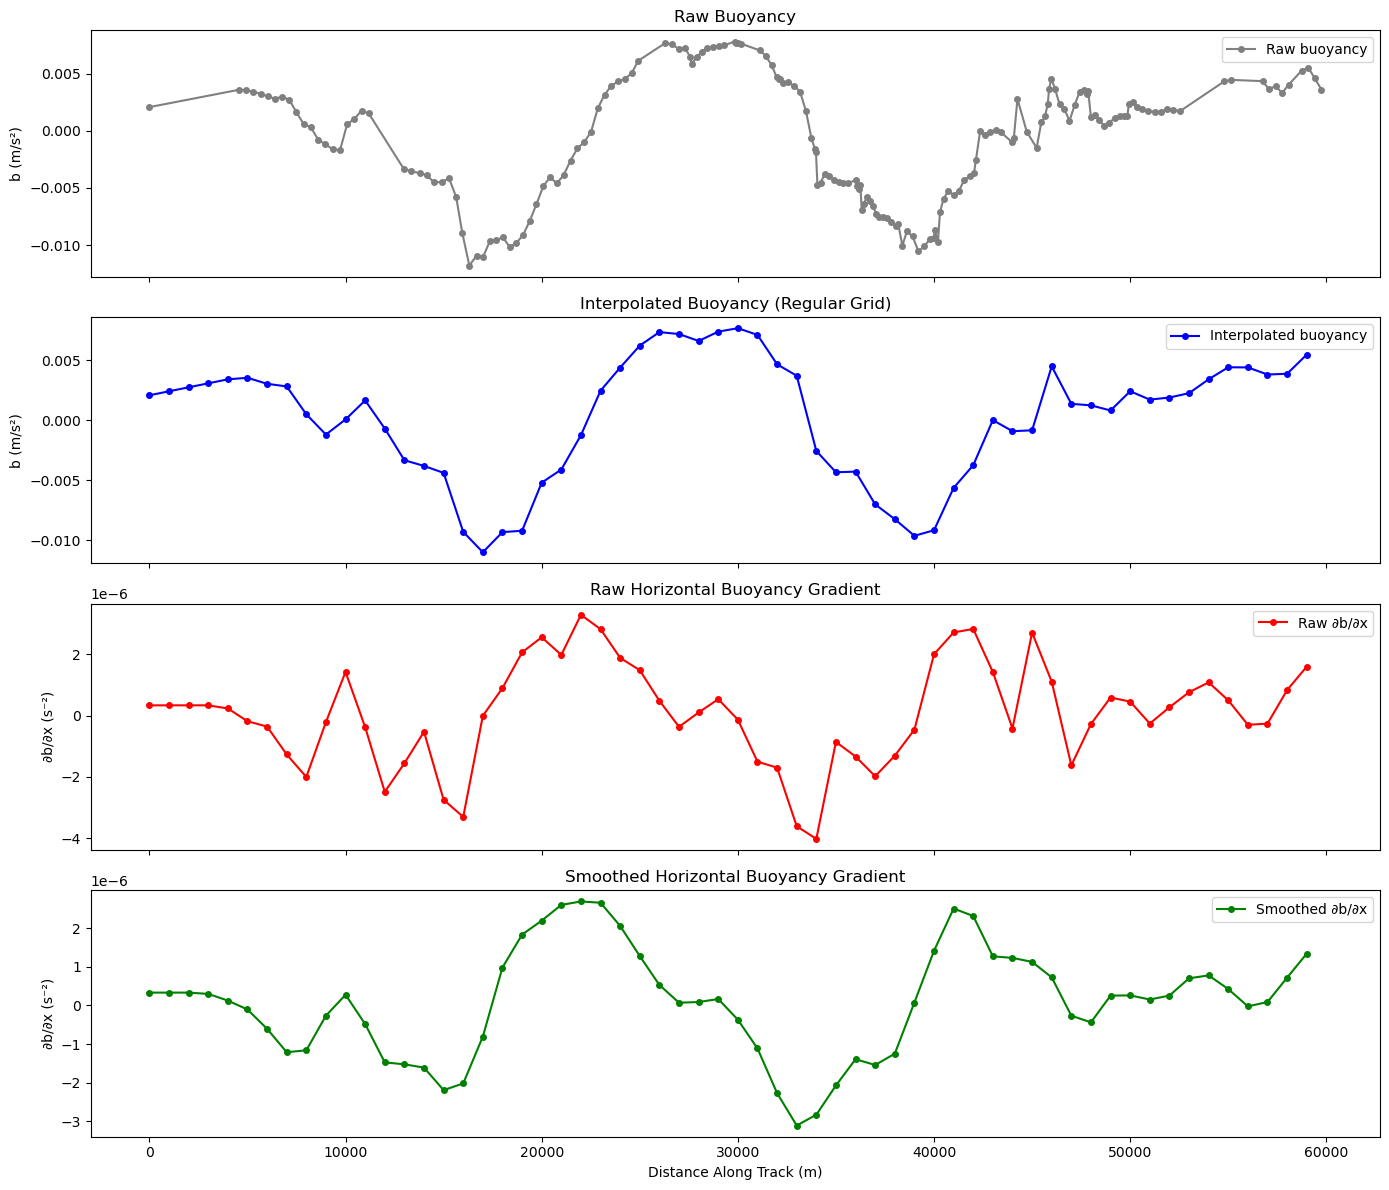

In [ ]:
from scipy.ndimage import uniform_filter1d
import matplotlib.pyplot as plt

# Smooth gradient
dbdx_reg_smooth = uniform_filter1d(dbdx_reg, size=3)

fig, axs = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# 1. Raw buoyancy (from measurements)
axs[0].plot(dist, b, 'o-', color='gray', markersize=4, label='Raw buoyancy')
axs[0].set_ylabel("b (m/s²)")
axs[0].set_title("Raw Buoyancy")
axs[0].legend()

# 2. Interpolated buoyancy
axs[1].plot(d_reg, b_reg, 'o-', color='blue', markersize=4, label='Interpolated buoyancy')
axs[1].set_ylabel("b (m/s²)")
axs[1].set_title("Interpolated Buoyancy (Regular Grid)")
axs[1].legend()

# 3. Raw gradient
axs[2].plot(d_reg, dbdx_reg, 'o-', color='red', markersize=4, label='Raw ∂b/∂x')
axs[2].set_ylabel("∂b/∂x (s⁻²)")
axs[2].set_title("Raw Horizontal Buoyancy Gradient")
axs[2].legend()

# 4. Smoothed gradient
axs[3].plot(d_reg, dbdx_reg_smooth, 'o-', color='green', markersize=4, label='Smoothed ∂b/∂x')
axs[3].set_ylabel("∂b/∂x (s⁻²)")
axs[3].set_xlabel("Distance Along Track (m)")
axs[3].set_title("Smoothed Horizontal Buoyancy Gradient")
axs[3].legend()

plt.tight_layout()
plt.show()


In [ ]:
print(f"Depth range: {np.nanmin(depth):.2f} to {np.nanmax(depth):.2f} m")

Depth range: 1.78 to 2.10 m


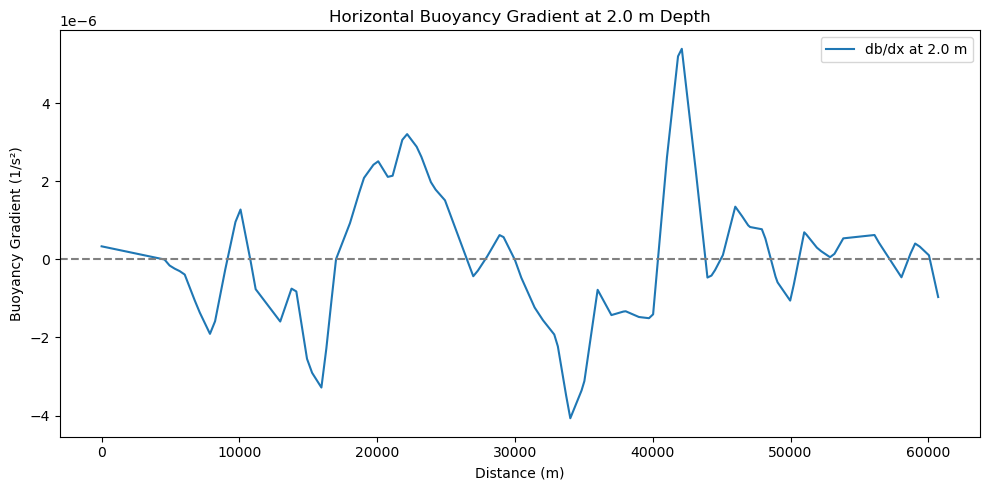

In [ ]:
# Plot
plt.figure(figsize=(10, 5))
plt.plot(dist, buoy_grad, label=f'db/dx at {target_depth} m')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Distance (m)')
plt.ylabel('Buoyancy Gradient (1/s²)')
plt.title(f'Horizontal Buoyancy Gradient at {target_depth} m Depth')
plt.legend()
plt.tight_layout()
plt.show()


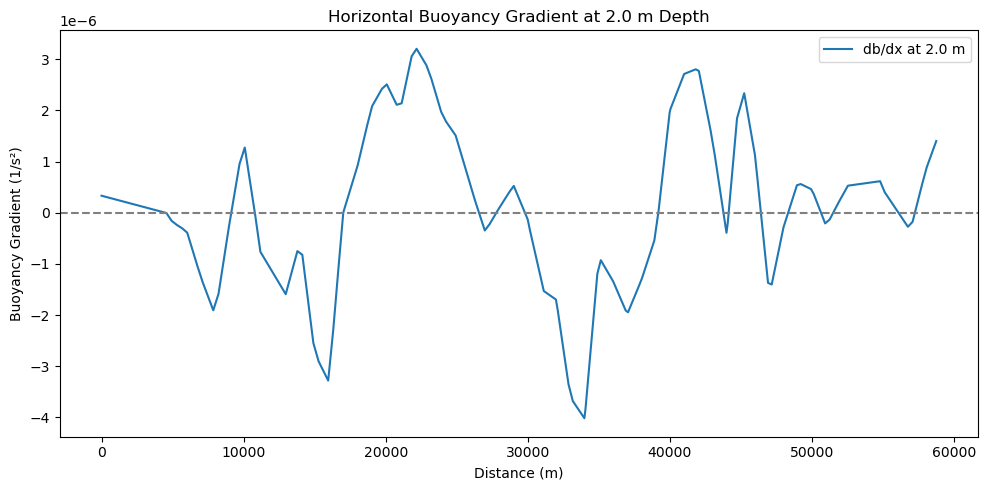

In [ ]:
# Plot
plt.figure(figsize=(10, 5))
plt.plot(dist, df_clean['buoy_grad'], label=f'db/dx at {target_depth} m')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Distance (m)')
plt.ylabel('Buoyancy Gradient (1/s²)')
plt.title(f'Horizontal Buoyancy Gradient at {target_depth} m Depth')
plt.legend()
plt.tight_layout()
plt.show()

Compute corilois and then EBF

In [ ]:
omega = 7.2921 * 10**-5  # Earth's rotation rate in rad/s
theta = 57  # Latitude in degrees

# Convert to radians
theta_rad = np.deg2rad(theta)

# Compute Coriolis parameter
f = 2 * omega * np.sin(theta_rad)

print(f"Coriolis parameter at {theta}°: {f:.3e} s⁻¹")


Coriolis parameter at 57°: 1.223e-04 s⁻¹


In [ ]:
# prepare the two source tables
bx   = df_filtered[['datetime', 'buoy_grad', 'Longitude', 'Latitude']]      
tau  = df_filtered[['datetime','tau']]  # 

# inner-join ⇒ keeps only timestamps present in **both** tables
combo = pd.merge(bx, tau, on='datetime', how='inner')


# Constants
Cp = 4000 # J kg-1 K-1 # specific heat of water
alpha = 10**-4
g = 9.82
tau_const = 0.02

#combo['Q_EBF'] = -((combo['buoy_grad'] * combo['tau']) / (f)) * ((Cp) / (alpha * g))
combo['Q_EBF'] = -((combo['buoy_grad'] * combo['tau']) / f) * (Cp / (alpha * g))


In [ ]:
# Constants
Cp = 4000 # J kg-1 K-1 # specific heat of water
alpha = 10**-4
g = 9.82
bx_const = 0.000000002
tau_const = 0.02

Q_EBF_const = -((bx_const * combo['tau']) / f) * (Cp / (alpha * g))

In [ ]:
print(df_filtered['tau'].mean())
print(df_filtered['tau'].max())
print(df_filtered['tau'].min())
print(df_filtered['tau'].describe())
print(df_filtered['windspeed_wind'].describe())

0.025732408920517282
0.11484221184978351
0.0
count    293.000000
mean       0.025732
std        0.030601
min        0.000000
25%        0.003692
50%        0.009998
75%        0.036471
max        0.114842
Name: tau, dtype: float64
count    293.000000
mean       3.016724
std        2.130059
min        0.000000
25%        1.400000
50%        2.300000
75%        4.400000
max        7.800000
Name: windspeed_wind, dtype: float64


In [ ]:
#Q_EBF = -((df_filtered["buoy_grad"] * df_filtered['tau']) / (f)) * ((Cp) / (alpha *g))
Q_EBF = -((df_clean["buoy_grad"] * df_clean['tau']) / (f)) * ((Cp) / (alpha *g))

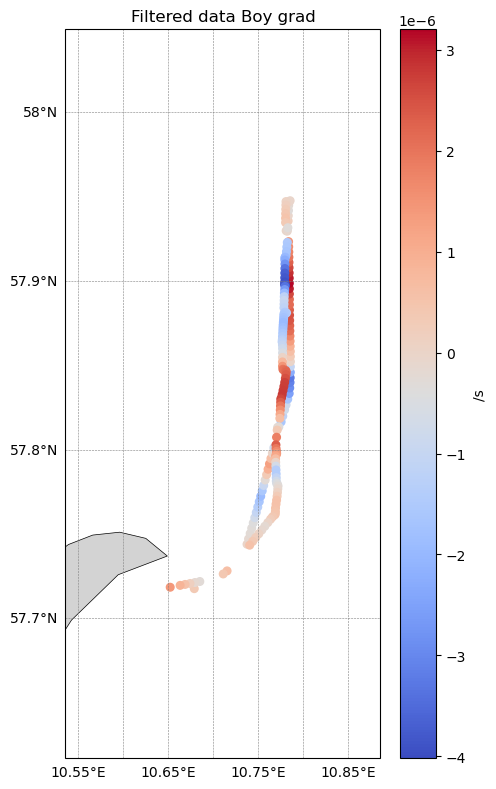

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Mercator())

# Define extent with buffer
lat_min, lat_max = df_filtered['Latitude'].min(), df_filtered['Latitude'].max()
lon_min, lon_max = df_filtered['Longitude'].min(), df_filtered['Longitude'].max()
extent = [lon_min - 0.1, lon_max + 0.1, lat_min - 0.1, lat_max + 0.1]

ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Gridlines with labels only on left and bottom
gl = ax.gridlines(draw_labels=True, linewidth=0.4, color="gray", linestyle="--")
gl.top_labels = False
gl.right_labels = False

# Scatter plot of Q_EBF
sc = ax.scatter(df_clean['Longitude'], df_clean['Latitude'],
                c=buoy_grad, cmap='coolwarm', s=30,
                transform=ccrs.PlateCarree())

# Colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('/s')

ax.set_title('Filtered data Boy grad')
plt.tight_layout()
plt.show()


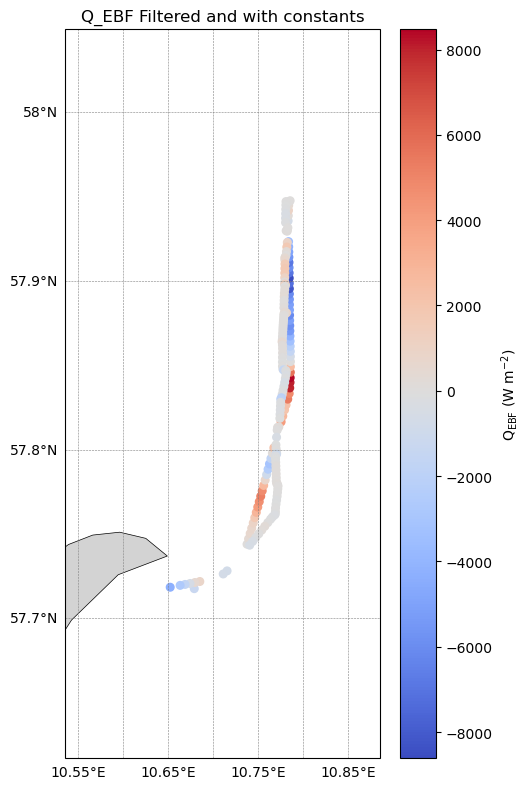

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Mercator())

# Define extent with buffer
lat_min, lat_max = df_filtered['Latitude'].min(), df_filtered['Latitude'].max()
lon_min, lon_max = df_filtered['Longitude'].min(), df_filtered['Longitude'].max()
extent = [lon_min - 0.1, lon_max + 0.1, lat_min - 0.1, lat_max + 0.1]

ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Gridlines with labels only on left and bottom
gl = ax.gridlines(draw_labels=True, linewidth=0.4, color="gray", linestyle="--")
gl.top_labels = False
gl.right_labels = False

# Scatter plot of Q_EBF
sc = ax.scatter(df_clean['Longitude'], df_clean['Latitude'],
                c=Q_EBF, cmap='coolwarm', s=30,
                transform=ccrs.PlateCarree())

# Colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Q$_{\\mathrm{EBF}}$ (W m$^{-2}$)')

ax.set_title('Q_EBF Filtered and with constants')
plt.tight_layout()
plt.show()
